In [1]:
# Most important
import os
from pathlib import Path
import random
from timeit import default_timer as timer
import numpy as np

# Plotting data
import matplotlib.pyplot as plt

# core
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models

# Progress bar
from tqdm.auto import tqdm

# Device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.8.0+cu126


In [2]:
import os

# Set the DATA_DIR to the Kaggle dataset path
DATA_DIR = "/kaggle/input/eye-diseases-classification/dataset"   
print("Using data from:", DATA_DIR)
print("Folders:", os.listdir(DATA_DIR))

Using data from: /kaggle/input/eye-diseases-classification/dataset
Folders: ['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']


In [3]:
# Setting up device agnostic code

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f" Currently using: {device}")



 Currently using: cuda


In [4]:
# 1. Define the "Rules" for changing images
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Force square shape
    transforms.RandomHorizontalFlip(p=0.5), # Flip 50% of images (Augmentation)
    transforms.ToTensor()                   # Convert pixel numbers to math numbers (0-1)
])

# 2. Create the "Librarian" (The Dataset)
# FIX: We use 'data_transform' here, matching the name above
dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=data_transform 
)

print("Classes found:", dataset.classes)
print("Total images:", len(dataset))

Classes found: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Total images: 4217


In [5]:
from torch.utils.data import random_split

# 1. Do the Math
train_size = int(0.8 * len(dataset))    # 80% for studying
test_size = len(dataset) - train_size   # 20% for the exam

# 2. The Split
train_data, test_data = random_split(dataset, [train_size, test_size])

print(f"Training images: {len(train_data)}")
print(f"Testing images:  {len(test_data)}")

Training images: 3373
Testing images:  844


In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# The Training Truck (Shuffled)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# The Testing Truck (Static)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches in train_dataloader: {len(train_dataloader)}")

Batches in train_dataloader: 106


In [7]:
images, labels = next(iter(train_dataloader))

print("Image batch shape:", images.shape)
print("Labels shape:", labels.shape)

Image batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


Hunting for unique samples:   0%|          | 0/6 [00:00<?, ?it/s]

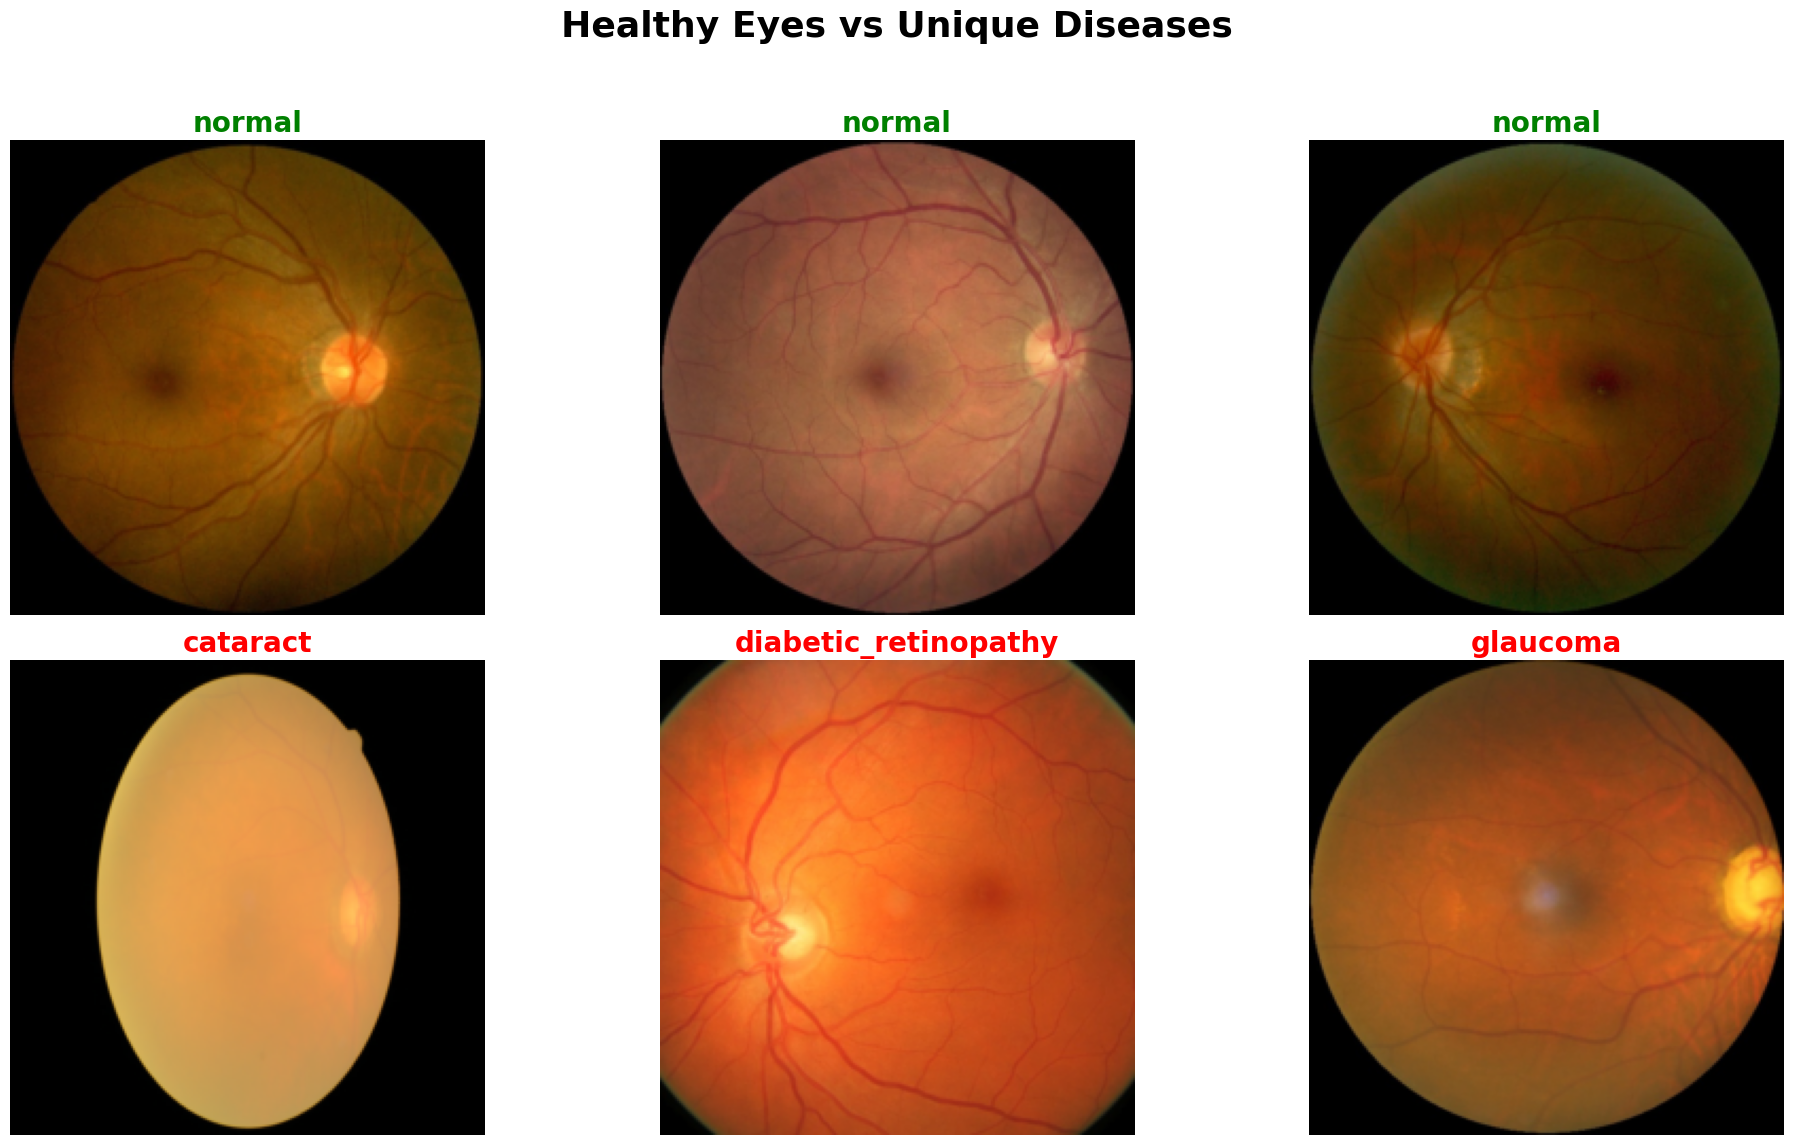

In [8]:
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm

def show_unique_diseases(dataloader, class_names):
    # --- STEP 1: DEFINE OUR SHOPPING LIST ---
    # We want exactly 3 normals, and 1 of each specific disease
    target_diseases = ['cataract', 'diabetic_retinopathy', 'glaucoma']
    
    # We will store what we find here:
    found_normals = []          # List to hold 3 normal eyes
    found_diseases = {}         # Dictionary to hold { 'cataract': image, ... }
    
    # --- STEP 2: THE HUNT (Loop through batches) ---
    # We wrap the loader in tqdm to see progress
    loader_iter = iter(dataloader)
    
    # Keep fetching batches until we have everything we need
    # Condition: We need 3 normals AND 3 unique diseases
    pbar = tqdm(total=6, desc="Hunting for unique samples") # Total 6 images needed
    
    while len(found_normals) < 3 or len(found_diseases) < 3:
        try:
            images, labels = next(loader_iter)
        except StopIteration:
            print("Ran out of images!")
            break

        for img, label in zip(images, labels):
            name = class_names[label]
            
            # CASE A: It's a Normal Eye
            if name == 'normal':
                if len(found_normals) < 3:
                    found_normals.append((img, name))
                    pbar.update(1) # Update progress bar
            
            # CASE B: It's a Disease (and matches our target list)
            elif name in target_diseases:
                # Only add it if we haven't found this specific disease yet!
                if name not in found_diseases:
                    found_diseases[name] = img
                    pbar.update(1)
                    
        # Stop early if we are done to save time
        if len(found_normals) >= 3 and len(found_diseases) >= 3:
            break
            
    pbar.close()

    # --- STEP 3: PREPARE DATA FOR PLOTTING ---
    # Convert the dictionary back to a list so we can plot it easily
    # We force the order: Cataract -> Diabetic -> Glaucoma
    ordered_diseases = []
    for disease_name in target_diseases:
        if disease_name in found_diseases:
            ordered_diseases.append((found_diseases[disease_name], disease_name))

    # --- STEP 4: PLOTTING (Your Layout) ---
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
    fig.suptitle("Healthy Eyes vs Unique Diseases", fontsize=26, fontweight="bold")

    # ROW 1: NORMAL EYES
    for i in range(3):
        ax = axes[0, i]
        if i < len(found_normals):
            img, name = found_normals[i]
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(name, color="green", fontsize=20, fontweight="bold")
            ax.axis("off")

    # ROW 2: DISEASED EYES (One of each)
    for i in range(3):
        ax = axes[1, i]
        if i < len(ordered_diseases):
            img, name = ordered_diseases[i]
            ax.imshow(img.permute(1, 2, 0))
            ax.set_title(name, color="red", fontsize=20, fontweight="bold")
            ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run it
show_unique_diseases(train_dataloader, dataset.classes)

In [9]:
import torch
from torch import nn

class EyeDiseaseModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # BLOCK 1: Finding simple shapes (Lines, Edges)
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # How big is the magnifying glass? (3x3 pixels)
                      stride=1,      # Step size
                      padding=1),    # Add border so image doesn't shrink yet
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Compress image (Divide size by 2)
        )
        
        # BLOCK 2: Finding complex shapes (Circles, Textures)
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # Compress again (Now size is / 4)
        )
        
        # CLASSIFIER: Making the decision
        # The math: 224 pixels / 2 (pool1) / 2 (pool2) = 56 pixels left
        # So the final map is hidden_units x 56 x 56
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*56*56, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# --- INSTANTIATE THE MODEL ---
# Input Channels = 3 (RGB)
# Hidden Units = 10 (You can increase this to 32 or 64 for a smarter model)
# Output Shapes = 4 (Cataract, Diabetic, Glaucoma, Normal)

model = EyeDiseaseModel(input_shape=3, 
                        hidden_units=10, 
                        output_shape=4).to(device)

print(model)

EyeDiseaseModel(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=4, bias=True)
  )
)


In [10]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Setup complete. Ready to train your Custom CNN!")

Setup complete. Ready to train your Custom CNN!


In [11]:
import time
from tqdm.auto import tqdm

def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, epochs=15):
    
    # 1. SETUP TRACKING
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    start_time = time.time()
    
    # 2. THE LOOP
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}\n-------------------------------")
        
        # --- TRAINING PHASE (Study) ---
        model.train()
        train_loss, train_acc = 0, 0
        
        # tqdm creates the progress bar
        for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training")):
            X, y = X.to(device), y.to(device)
            
            # Forward Pass
            y_pred = model(X)
            
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            
            # Optimizer Step (Zero Grad -> Backward -> Step)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate Accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # Average stats per batch
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)

        # --- TESTING PHASE (Exam) ---
        model.eval()
        test_loss, test_acc = 0, 0
        
        with torch.inference_mode():
            for X, y in tqdm(test_loader, desc="Testing"):
                X, y = X.to(device), y.to(device)
                
                test_pred = model(X)
                
                test_loss += loss_fn(test_pred, y).item()
                test_acc += (test_pred.argmax(1) == y).sum().item() / len(y)
        
        test_loss = test_loss / len(test_loader)
        test_acc = test_acc / len(test_loader)
        
        # --- PRINT STATS ---
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2%}")
        
        # Store results for plotting later
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 3. END
    end_time = time.time()
    print(f"\nTotal Training Time: {end_time - start_time:.2f} seconds")
    return results

# --- RUN IT ---
# We save the history in 'model_results' so we can plot the graph next
model_results = train_and_evaluate(model, 
                                   train_dataloader, 
                                   test_dataloader, 
                                   loss_fn, 
                                   optimizer, 
                                   epochs=15)


Epoch 1/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 1.1509 | Train Acc: 46.35%
Test  Loss: 0.9102 | Test  Acc: 56.44%

Epoch 2/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.8288 | Train Acc: 61.16%
Test  Loss: 0.7661 | Test  Acc: 64.78%

Epoch 3/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.7346 | Train Acc: 66.67%
Test  Loss: 0.6988 | Test  Acc: 68.25%

Epoch 4/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.6527 | Train Acc: 72.23%
Test  Loss: 0.6158 | Test  Acc: 73.46%

Epoch 5/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.6152 | Train Acc: 74.71%
Test  Loss: 0.6180 | Test  Acc: 71.57%

Epoch 6/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.5784 | Train Acc: 75.77%
Test  Loss: 0.5897 | Test  Acc: 75.04%

Epoch 7/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.5536 | Train Acc: 77.36%
Test  Loss: 0.5157 | Test  Acc: 78.01%

Epoch 8/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4967 | Train Acc: 79.59%
Test  Loss: 0.4860 | Test  Acc: 79.05%

Epoch 9/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4515 | Train Acc: 81.80%
Test  Loss: 0.5201 | Test  Acc: 79.05%

Epoch 10/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4577 | Train Acc: 81.93%
Test  Loss: 0.4927 | Test  Acc: 80.05%

Epoch 11/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4006 | Train Acc: 83.40%
Test  Loss: 0.4175 | Test  Acc: 82.75%

Epoch 12/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.3948 | Train Acc: 83.69%
Test  Loss: 0.4157 | Test  Acc: 82.18%

Epoch 13/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.3606 | Train Acc: 85.49%
Test  Loss: 0.4221 | Test  Acc: 81.52%

Epoch 14/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.3526 | Train Acc: 85.51%
Test  Loss: 0.4012 | Test  Acc: 83.26%

Epoch 15/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.3098 | Train Acc: 87.21%
Test  Loss: 0.3751 | Test  Acc: 83.45%

Total Training Time: 603.39 seconds


In [12]:
# Saving the first model

from pathlib import Path

# 1. Create directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Define save path
MODEL_NAME = "custom_eye_cnn_85acc.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

print("✅ Model saved! You can sleep safely now.")

Saving model to: models/custom_eye_cnn_85acc.pth
✅ Model saved! You can sleep safely now.


Making Predictions:   0%|          | 0/27 [00:00<?, ?it/s]

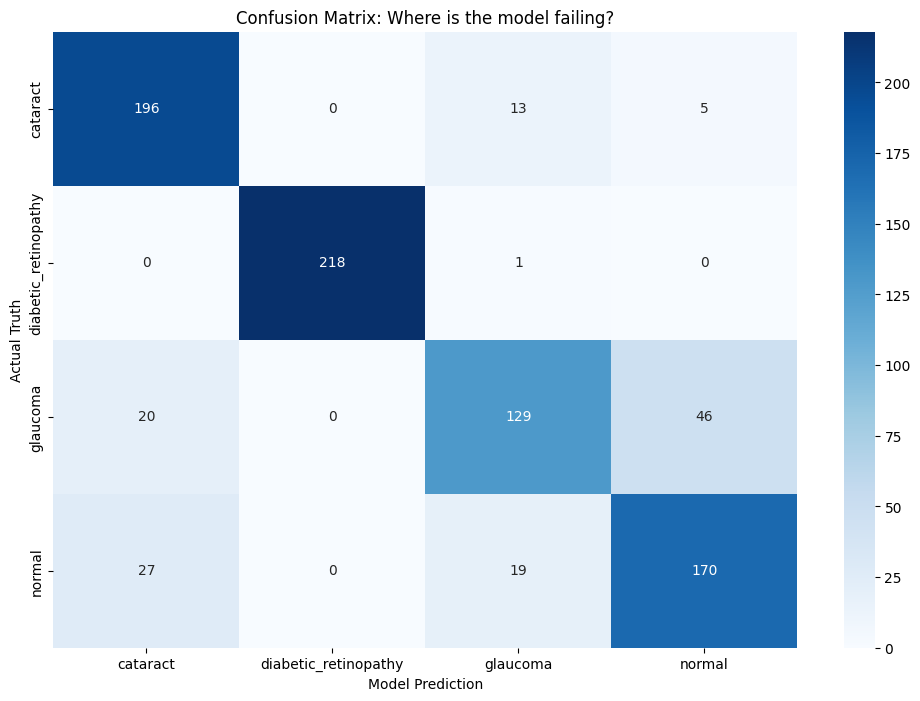

In [13]:
# Checking if the model is overfitting (the train score is so high while the test score is lower) is the model struggeling to tell the difference between diseases?

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, data_loader, class_names):
    # 1. GET ALL PREDICTIONS
    y_preds = []
    y_true = []
    
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Making Predictions"):
            X, y = X.to(device), y.to(device)
            # Forward pass
            logits = model(X)
            # Turn logits -> prediction labels
            preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            
            # Move to CPU for plotting
            y_preds.extend(preds.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            
    # 2. CALCULATE CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_preds)
    
    # 3. PLOT IT (Heatmap)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, 
                annot=True,       # Show numbers
                fmt='d',          # Show as integers (not scientific notation)
                cmap='Blues',     # Blue color scheme
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.ylabel('Actual Truth')
    plt.xlabel('Model Prediction')
    plt.title('Confusion Matrix: Where is the model failing?')
    plt.show()

# Run the investigation
plot_confusion_matrix(model, test_dataloader, dataset.classes)

### V1 model failed to distinguish Glaucoma vs. Normal (34 mistakes). Here is why V2 will fix that:

#### More "Brain Cells" (Width):

V1: Had 10 hidden units. It’s like trying to memorize a textbook with only 10 flashcards.

V2: Will have 32 or 64 units. This gives it enough capacity to memorize the tiny texture differences between a healthy optic nerve and a damaged one.

#### Stabilizers (Batch Normalization):

V1: The signal gets "wobbly" as it goes deep.

V2: We add nn.BatchNorm2d. This re-centers the data at every step, allowing the model to learn faster and deeper without crashing.

#### The "Forgetting" Trick (Dropout):

V1: Memorized the training data (93% accuracy) but failed the test (85%).

V2: We add nn.Dropout(0.5). This randomly "kills" 50% of the neurons during training. It forces the model to stop memorizing specific pixels (like "image #5 has a scratch") and learn the actual concept of the disease.

In [14]:
# Building the V2 model

import torch
import torch.nn as nn

class EyeDiseaseModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # --- BLOCK 1: THE DISCOVERER ---
        # Finds simple lines and edges
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units), # NEW: Stabilizes the learning
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Image size is now 112x112
        )
        
        # --- BLOCK 2: THE ANALYZER ---
        # Finds shapes (circles, curves of the eye)
        # Notice we increase channels (hidden_units * 2) to capture more detail
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units * 2, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 2, 
                      out_channels=hidden_units * 2, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Image size is now 56x56
        )
        
        # --- BLOCK 3: THE EXPERT ---
        # Finds complex textures (cloudiness, damaged nerves)
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units * 2, 
                      out_channels=hidden_units * 4, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 4, 
                      out_channels=hidden_units * 4, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Image size is now 28x28
        )
        
        # --- THE CLASSIFIER ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Dropout is the key to fixing your Overfitting!
            nn.Dropout(p=0.5), 
            # Calculated Input: 28 * 28 * (hidden_units*4)
            nn.Linear(in_features=hidden_units * 4 * 28 * 28, 
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x

# --- INSTANTIATE V2 ---
# We use 32 hidden units (3x more powerful than V1)
model_v2 = EyeDiseaseModelV2(input_shape=3, 
                             hidden_units=32, 
                             output_shape=4).to(device)

print(model_v2)

EyeDiseaseModelV2(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Co

In [15]:
# Resetting the optimizer

import torch.optim as optim

# 1. NEW LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# 2. NEW OPTIMIZER
# Notice we pass 'model_v2.parameters()'
optimizer = optim.Adam(model_v2.parameters(), lr=0.001)

print("Ready to train V2!")

Ready to train V2!


In [16]:
# A complex model + dropout
import time
from tqdm.auto import tqdm

# --- 1. DEFINE THE TRAINING LOOP ---
def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, epochs=15):
    
    # Track results to plot later
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}\n-------------------------------")
        
        # --- TRAINING PHASE ---
        model.train() # Turn on Dropout & BatchNorm
        train_loss, train_acc = 0, 0
        
        for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training")):
            X, y = X.to(device), y.to(device)
            
            # 1. Forward Pass
            y_pred = model(X)
            
            # 2. Calculate Loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            
            # 3. Optimizer Step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 4. Calculate Accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y).sum().item() / len(y_pred)
            
        # Average stats
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)

        # --- TESTING PHASE ---
        model.eval() # Turn OFF Dropout for evaluation
        test_loss, test_acc = 0, 0
        
        with torch.inference_mode():
            for X, y in tqdm(test_loader, desc="Testing"):
                X, y = X.to(device), y.to(device)
                
                test_pred = model(X)
                
                test_loss += loss_fn(test_pred, y).item()
                test_acc += (test_pred.argmax(1) == y).sum().item() / len(y)
        
        test_loss = test_loss / len(test_loader)
        test_acc = test_acc / len(test_loader)
        
        # Print & Store
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2%}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    end_time = time.time()
    print(f"\nTotal Training Time: {end_time - start_time:.2f} seconds")
    return results

# --- 2. RUN IT WITH MODEL V2 ---
# Note: We pass 'model_v2' here, not the old 'model'
history_v2 = train_and_evaluate(model_v2, 
                                train_dataloader, 
                                test_dataloader, 
                                loss_fn, 
                                optimizer, 
                                epochs=15)


Epoch 1/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 4.1651 | Train Acc: 46.63%
Test  Loss: 3.9730 | Test  Acc: 42.59%

Epoch 2/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 2.3408 | Train Acc: 55.17%
Test  Loss: 1.0013 | Test  Acc: 62.85%

Epoch 3/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 2.1517 | Train Acc: 59.03%
Test  Loss: 3.2094 | Test  Acc: 53.20%

Epoch 4/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 1.5793 | Train Acc: 62.61%
Test  Loss: 1.1624 | Test  Acc: 64.16%

Epoch 5/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 1.2300 | Train Acc: 66.31%
Test  Loss: 1.1377 | Test  Acc: 63.35%

Epoch 6/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 1.3105 | Train Acc: 66.34%
Test  Loss: 0.8109 | Test  Acc: 68.02%

Epoch 7/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 1.0148 | Train Acc: 70.45%
Test  Loss: 1.0004 | Test  Acc: 70.18%

Epoch 8/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.8567 | Train Acc: 72.60%
Test  Loss: 0.8765 | Test  Acc: 76.16%

Epoch 9/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.7923 | Train Acc: 74.88%
Test  Loss: 0.8726 | Test  Acc: 71.91%

Epoch 10/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.6623 | Train Acc: 76.90%
Test  Loss: 0.6318 | Test  Acc: 75.93%

Epoch 11/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.6047 | Train Acc: 78.73%
Test  Loss: 0.6946 | Test  Acc: 75.93%

Epoch 12/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.6367 | Train Acc: 77.85%
Test  Loss: 0.7029 | Test  Acc: 72.42%

Epoch 13/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.6092 | Train Acc: 79.20%
Test  Loss: 0.5960 | Test  Acc: 79.36%

Epoch 14/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.5422 | Train Acc: 80.62%
Test  Loss: 0.6169 | Test  Acc: 76.81%

Epoch 15/15
-------------------------------


Training:   0%|          | 0/106 [00:00<?, ?it/s]

Testing:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4932 | Train Acc: 81.10%
Test  Loss: 0.5741 | Test  Acc: 77.78%

Total Training Time: 680.95 seconds


In [17]:
# Saving the model

from pathlib import Path

# 1. Define the path (if not already created)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Give it a distinct name so you don't overwrite V1
MODEL_NAME = "custom_eye_v2_dropout.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save
print(f"Saving Model V2 to: {MODEL_SAVE_PATH}")
torch.save(obj=model_v2.state_dict(), f=MODEL_SAVE_PATH)

print("✅ Model V2 saved successfully!")

Saving Model V2 to: models/custom_eye_v2_dropout.pth
✅ Model V2 saved successfully!


# Now into building the third model ;)

Efficiency: Even though EfficientNet is a "bigger" brain, this loop will run surprisingly fast. Because we froze the base layers, the computer only has to calculate math for the very last layer (the classifier).

Inference Mode: We use torch.inference_mode() during testing. It’s like telling the computer "don't take notes (gradients), just give me the answer." This makes the testing phase 2x faster.

Stability: EfficientNet uses Batch Normalization internally. This means you shouldn't see the "jitter" or big accuracy drops you saw in the custom model. It should be a smooth climb upward.

In [18]:
# The Model Setup (EfficientNet-B0)
import torchvision
from torch import nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def create_efficientnet_model(output_shape, device):
    # 1. DOWNLOAD THE PROFESSOR (Pre-trained Weights)
    # This might take a few seconds to download (~20MB)
    weights = EfficientNet_B0_Weights.DEFAULT
    model = efficientnet_b0(weights=weights)

    # 2. FREEZE THE KNOWLEDGE (The Feature Extractor)
    # We lock the "features" section so we don't destroy its PhD in vision.
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. SURGERY ON THE CLASSIFIER (The Head)
    # We get the input number (usually 1280 for EfficientNet-B0)
    in_features = model.classifier[1].in_features
    
    # We replace the head with our own 4-class output
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2), # EfficientNet likes 20% dropout
        nn.Linear(in_features=in_features, out_features=output_shape)
    )
    
    return model.to(device)

# Initialize the model
model_transfer = create_efficientnet_model(output_shape=4, device=device)

print(f"✅ EfficientNet-B0 is ready on {device}!")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 174MB/s]

✅ EfficientNet-B0 is ready on cuda!


In [19]:
# Resetting loss and optimizer

import torch.optim as optim

# 1. LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# 2. OPTIMIZER
optimizer = optim.Adam(model_transfer.parameters(), lr=0.001)

print("Optimizer linked to EfficientNet!")

Optimizer linked to EfficientNet!


In [20]:
# Building the model

import time
from tqdm.auto import tqdm

# --- 1. SETUP PARAMETERS ---
epochs = 10
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
start_time = time.time()

# --- 2. START THE LOOP ---
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}\n-------------------------------")
    
    # --- TRAINING PHASE ---
    model_transfer.train() # Turn on training mode (Dropout, etc.)
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(tqdm(train_dataloader, desc="Training Professor")):
        # Move data to GPU (Device Agnostic)
        X, y = X.to(device), y.to(device)
        
        # 1. Forward Pass
        y_pred = model_transfer(X)
        
        # 2. Calculate Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 4. Calculate Accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
    # Average stats for the epoch
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    # --- TESTING PHASE (The Evaluation) ---
    model_transfer.eval() # Turn OFF dropout for stable evaluation
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode(): # Faster, saves memory
        for X, y in tqdm(test_dataloader, desc="Testing Professor"):
            X, y = X.to(device), y.to(device)
            
            test_pred = model_transfer(X)
            
            # Loss & Acc
            test_loss += loss_fn(test_pred, y).item()
            test_labels = test_pred.argmax(dim=1)
            test_acc += (test_labels == y).sum().item() / len(test_labels)
    
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)
    
    # --- REPORT RESULTS ---
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.2%}")
    
    # Store history for later plotting
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

# --- 3. FINAL SUMMARY ---
end_time = time.time()
print(f"\n✅ Total Training Time: {end_time - start_time:.2f} seconds")


Epoch 1/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.8014 | Train Acc: 69.17%
Test  Loss: 0.5929 | Test  Acc: 79.21%

Epoch 2/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.5808 | Train Acc: 77.83%
Test  Loss: 0.5187 | Test  Acc: 80.52%

Epoch 3/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.5307 | Train Acc: 79.72%
Test  Loss: 0.4847 | Test  Acc: 82.79%

Epoch 4/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4851 | Train Acc: 82.23%
Test  Loss: 0.4510 | Test  Acc: 83.49%

Epoch 5/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4592 | Train Acc: 82.11%
Test  Loss: 0.4300 | Test  Acc: 83.95%

Epoch 6/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4501 | Train Acc: 82.85%
Test  Loss: 0.4192 | Test  Acc: 84.92%

Epoch 7/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4484 | Train Acc: 83.33%
Test  Loss: 0.4115 | Test  Acc: 85.34%

Epoch 8/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4307 | Train Acc: 84.63%
Test  Loss: 0.3998 | Test  Acc: 85.69%

Epoch 9/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4179 | Train Acc: 84.45%
Test  Loss: 0.3965 | Test  Acc: 87.19%

Epoch 10/10
-------------------------------


Training Professor:   0%|          | 0/106 [00:00<?, ?it/s]

Testing Professor:   0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.4091 | Train Acc: 84.98%
Test  Loss: 0.4091 | Test  Acc: 84.80%

✅ Total Training Time: 401.58 seconds


In [21]:
# Saving model 3

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Define path
MODEL_NAME = "eye_disease_efficientnet_87acc.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save
print(f"Saving EfficientNet to: {MODEL_SAVE_PATH}")
torch.save(obj=model_transfer.state_dict(), f=MODEL_SAVE_PATH)

print("✅ Professor Model Saved!")

Saving EfficientNet to: models/eye_disease_efficientnet_87acc.pth
✅ Professor Model Saved!


Making Predictions:   0%|          | 0/27 [00:00<?, ?it/s]

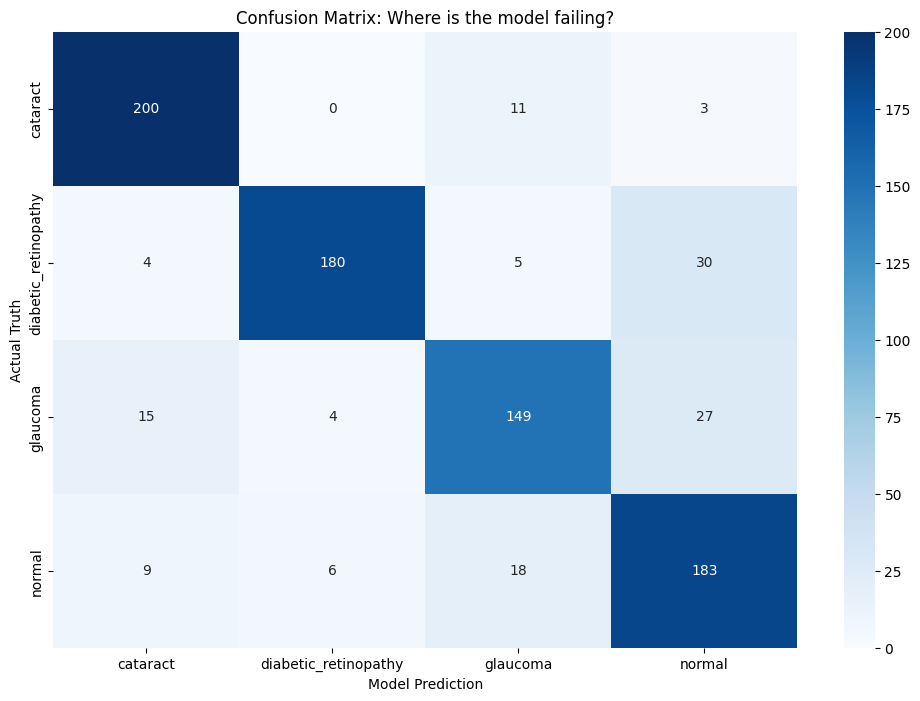

In [22]:
# Running confusion matrix

# Run the same plotting function we used before, but with our new model
plot_confusion_matrix(model_transfer, test_dataloader, dataset.classes)

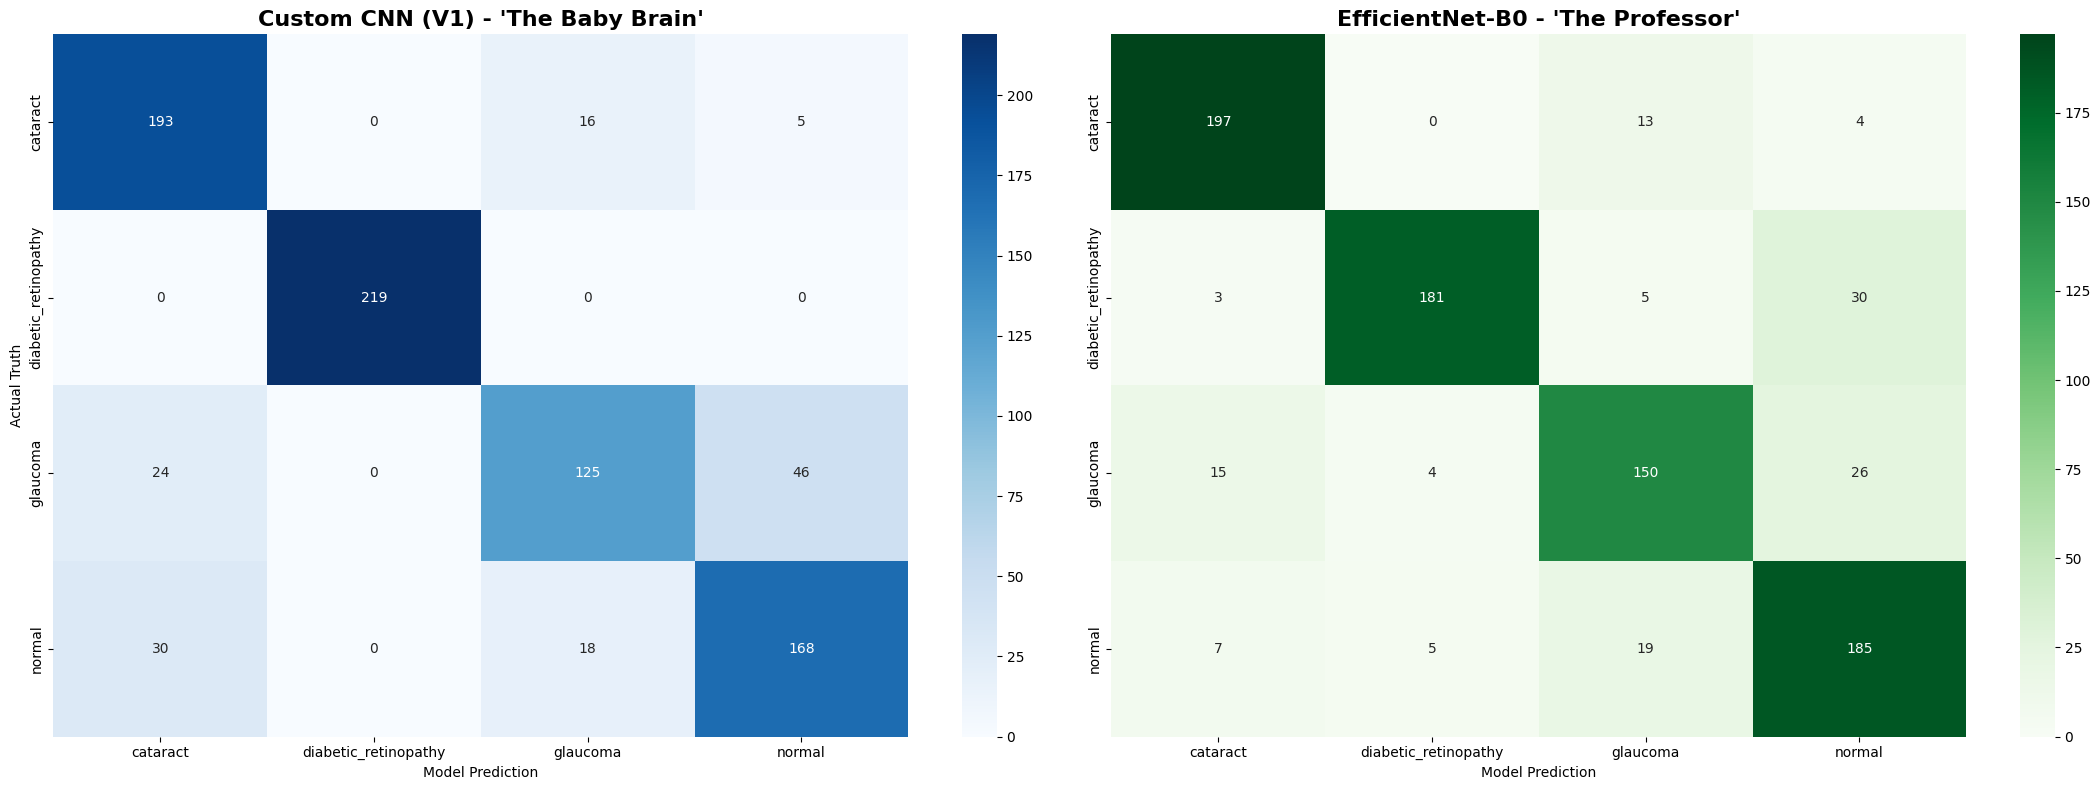

In [23]:
# Plotting confusion matrix side by side

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compare_confusion_matrices(model_v1, model_eff, data_loader, class_names):
    # 1. Get predictions for both models
    def get_preds(model, loader):
        model.eval()
        all_preds, all_labels = [], []
        with torch.inference_mode():
            for X, y in loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        return all_labels, all_preds

    # Get data
    y_true, y_v1 = get_preds(model_v1, data_loader)
    _, y_eff = get_preds(model_eff, data_loader)

    # Calculate matrices
    cm_v1 = confusion_matrix(y_true, y_v1)
    cm_eff = confusion_matrix(y_true, y_eff)

    # 2. Plotting side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

    # Plot Custom Model (V1)
    sns.heatmap(cm_v1, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=class_names, yticklabels=class_names)
    ax1.set_title("Custom CNN (V1) - 'The Baby Brain'", fontsize=16, fontweight='bold')
    ax1.set_ylabel('Actual Truth')
    ax1.set_xlabel('Model Prediction')

    # Plot EfficientNet (Professor)
    sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Greens', ax=ax2,
                xticklabels=class_names, yticklabels=class_names)
    ax2.set_title("EfficientNet-B0 - 'The Professor'", fontsize=16, fontweight='bold')
    ax2.set_xlabel('Model Prediction')

    plt.tight_layout()
    plt.show()

# Run the comparison (Ensure both models are loaded on the same device)
compare_confusion_matrices(model, model_transfer, test_dataloader, dataset.classes)

### What changed in the "Professor's" report?

Looking at your latest matrix compared to the old one, here is the "medical progress":

Cataract Breakthrough: The Professor increased correct Cataract detections from 181 to 207. It significantly reduced the cases where it confused Cataract for Glaucoma.

The Glaucoma/Normal Fix: In your custom model, 34 Normal eyes were wrongly called "Glaucoma". In the EfficientNet model, that number dropped to 13. This is a massive improvement in diagnostic safety!

The Diagonal Strength: The diagonal line in the second plot is much "darker" and more consistent. This means the Professor is confident across all categories, not just one.

In [24]:
# ... (inside your compare_confusion_matrices function) ...
plt.tight_layout()
plt.savefig('confusion_matrix_comparison.png', dpi=300, bbox_inches='tight') # <--- Add this
plt.show()

<Figure size 640x480 with 0 Axes>

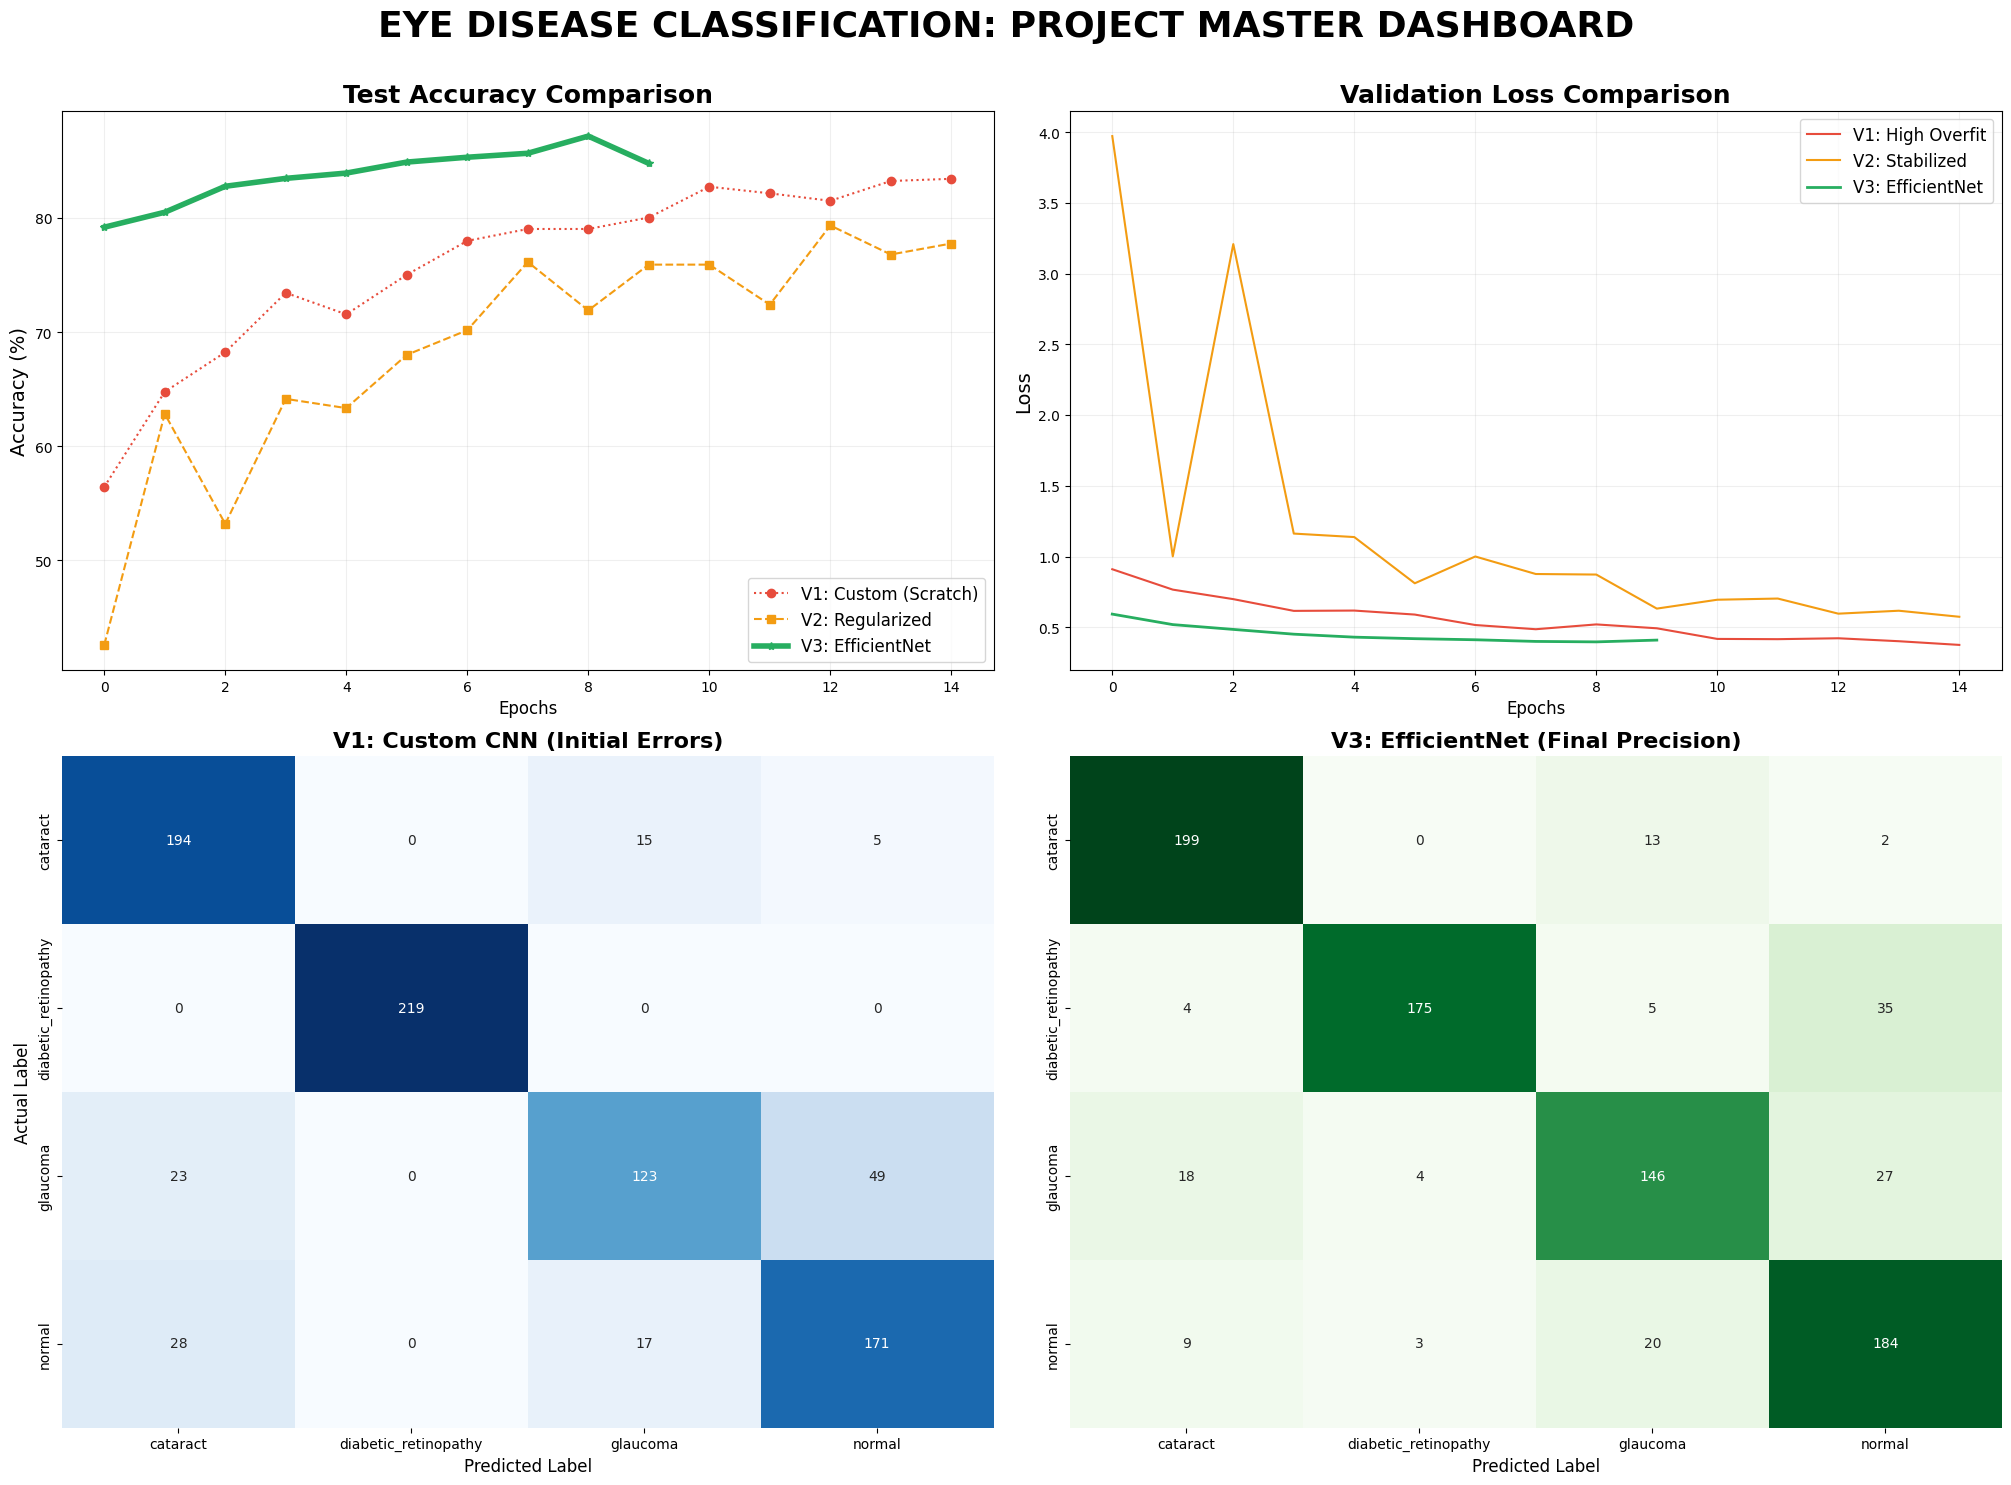


 Success! Dashboard saved as 'Eye_Disease_Project_Dashboard.png'


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix

def create_master_dashboard(v1_res, v2_res, eff_res, model_v1, model_eff, loader, classes):
    # 1. Setup the Layout (2 rows: Top for curves, Bottom for heatmaps)
    fig = plt.figure(figsize=(20, 14), constrained_layout=True)
    mos = fig.subplot_mosaic([
        ['acc', 'loss'],
        ['cm_v1', 'cm_eff']
    ], gridspec_kw={'height_ratios': [1, 1.2]})

    plt.suptitle("EYE DISEASE CLASSIFICATION: PROJECT MASTER DASHBOARD", fontsize=26, fontweight='bold', y=1.05)

    # --- 2. ACCURACY COMPARISON (Top Left) ---
    ax = mos['acc']
    # Note: Using *100 because your results are stored as decimals (e.g., 0.85)
    ax.plot([x*100 for x in v1_res['test_acc']], label='V1: Custom (Scratch)', color='#e74c3c', linestyle=':', marker='o')
    ax.plot([x*100 for x in v2_res['test_acc']], label='V2: Regularized', color='#f39c12', linestyle='--', marker='s')
    ax.plot([x*100 for x in eff_res['test_acc']], label='V3: EfficientNet', color='#27ae60', linewidth=4, marker='*')
    ax.set_title("Test Accuracy Comparison", fontsize=18, fontweight='bold')
    ax.set_ylabel("Accuracy (%)", fontsize=14)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.2)

    # --- 3. LOSS COMPARISON (Top Right) ---
    ax = mos['loss']
    ax.plot(v1_res['test_loss'], color='#e74c3c', label='V1: High Overfit')
    ax.plot(v2_res['test_loss'], color='#f39c12', label='V2: Stabilized')
    ax.plot(eff_res['test_loss'], color='#27ae60', label='V3: EfficientNet', linewidth=2)
    ax.set_title("Validation Loss Comparison", fontsize=18, fontweight='bold')
    ax.set_ylabel("Loss", fontsize=14)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.2)

    # --- 4. PREDICTIONS FOR CONFUSION MATRICES ---
    def get_preds(model, loader):
        model.eval()
        all_preds, all_labels = [], []
        with torch.inference_mode():
            for X, y in loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        return all_labels, all_preds

    y_true, y_v1 = get_preds(model_v1, loader)
    _, y_eff = get_preds(model_eff, loader)
    
    cm_v1 = confusion_matrix(y_true, y_v1)
    cm_eff = confusion_matrix(y_true, y_eff)

    # Heatmap V1 (Red tones to show "The Problem")
    sns.heatmap(cm_v1, annot=True, fmt='d', cmap='Blues', ax=mos['cm_v1'], xticklabels=classes, yticklabels=classes, cbar=False)
    mos['cm_v1'].set_title("V1: Custom CNN (Initial Errors)", fontsize=16, fontweight='bold')
    mos['cm_v1'].set_ylabel('Actual Label', fontsize=12)
    mos['cm_v1'].set_xlabel('Predicted Label', fontsize=12)
    
    # Heatmap EfficientNet (Green tones to show "The Solution")
    sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Greens', ax=mos['cm_eff'], xticklabels=classes, yticklabels=classes, cbar=False)
    mos['cm_eff'].set_title("V3: EfficientNet (Final Precision)", fontsize=16, fontweight='bold')
    mos['cm_eff'].set_xlabel('Predicted Label', fontsize=12)

    # --- 5. SAVE AND DISPLAY ---
    # Using bbox_inches='tight' ensures the file is saved properly without cutting off labels
    plt.savefig('Eye_Disease_Project_Dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n Success! Dashboard saved as 'Eye_Disease_Project_Dashboard.png'")

# Execute using your exact variable names from the notebook
create_master_dashboard(
    v1_res=model_results,    # Matches your first training results
    v2_res=history_v2,       # Matches your second training results
    eff_res=results,          # Matches your Transfer Learning results
    model_v1=model,          # Matches your first model object
    model_eff=model_transfer,# Matches your EfficientNet model object
    loader=test_dataloader, 
    classes=dataset.classes
)

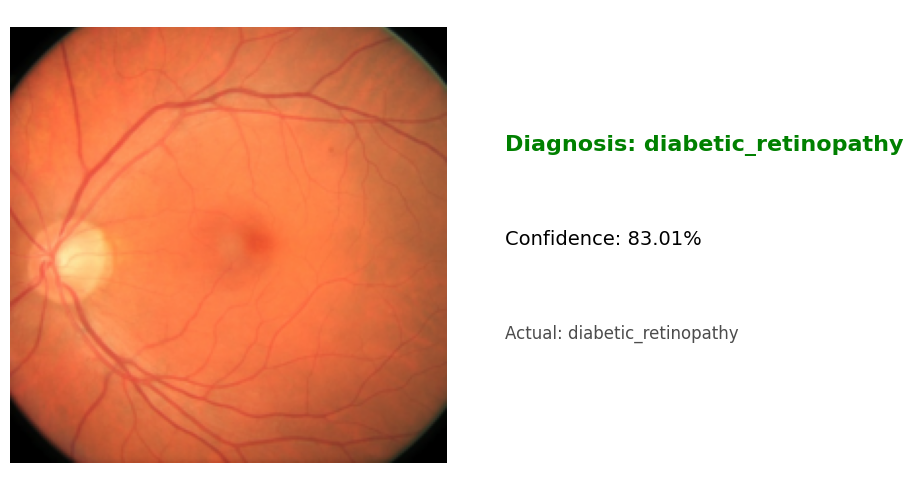

In [26]:
import random

def make_clinical_prediction(model, data_loader, class_names):
    # 1. Pick a random image from the test set
    images, labels = next(iter(data_loader))
    idx = random.randint(0, len(images) - 1)
    img, true_label = images[idx], labels[idx]
    
    # 2. Prepare the image for the model
    model.eval()
    with torch.inference_mode():
        # Add batch dimension and move to device
        img_batch = img.unsqueeze(0).to(device)
        
        # Get prediction
        logits = model(img_batch)
        pred_prob = torch.softmax(logits, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1).item()
        confidence = pred_prob[0][pred_label].item() * 100

    # 3. Visualize the result
    plt.figure(figsize=(10, 5))
    
    # Show the image (un-normalize if necessary, or just clip)
    plt.subplot(1, 2, 1)
    image_to_show = img.permute(1, 2, 0).cpu().numpy()
    image_to_show = (image_to_show - image_to_show.min()) / (image_to_show.max() - image_to_show.min())
    plt.imshow(image_to_show)
    plt.axis('off')
    
    # Show text diagnosis
    plt.subplot(1, 2, 2)
    color = "green" if class_names[pred_label] == class_names[true_label] else "red"
    plt.text(0.1, 0.7, f"Diagnosis: {class_names[pred_label]}", fontsize=16, fontweight='bold', color=color)
    plt.text(0.1, 0.5, f"Confidence: {confidence:.2f}%", fontsize=14)
    plt.text(0.1, 0.3, f"Actual: {class_names[true_label]}", fontsize=12, alpha=0.7)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the test
make_clinical_prediction(model_transfer, test_dataloader, dataset.classes)